# Mellors MSDS 696 Practicum 2 - Notebook 3:  Target Feature, Modelling, and Tuning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight



In [ ]:
df_clean = pd.read_csv("/content/drive/MyDrive/Mellors - MSDS 696 - Practicum 2/df_clean.csv")

/tmp/ipython-input-4144628424.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv("/content/drive/MyDrive/Mellors - MSDS 696 - Practicum 2/df_clean.csv")


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101502 entries, 0 to 101501
Data columns (total 23 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   age_group                            101502 non-null  object 
 1   fine_amount                          101502 non-null  float64
 2   criminal_history_dummy               101502 non-null  float64
 3   sentenced_to_days_in_prison_dummy    101502 non-null  float64
 4   fine_imposed_dummy                   101502 non-null  float64
 5   gender                               101502 non-null  object 
 6   citizenship_dummy                    101502 non-null  float64
 7   conviction_thru_plea_or_trial_dummy  101502 non-null  float64
 8   education_level                      101502 non-null  float64
 9   number_of_crimes_committed           101502 non-null  float64
 10  number_of_dependents                 101502 non-null  float64
 11  presentence_d

In [ ]:
df_clean = df_clean.drop(columns=['sentence_type'])

## Target Feature

**Below:** I am generating my target feature, which will use a set of rules that are outlined using a combination of values related to how long (sentence_in_months) that someone was sentence to and how much (fine_amount) they had to pay. I tested different values, and found that the current ones produced a good split between the three severity levels.

In [ ]:
MONTHS_LOW  = 1
MONTHS_MED  = 12
MONTHS_HIGH = 60
FINE_HIGH   = 10_000

s = df_clean['sentence_in_months']
f = df_clean['fine_amount']

# bands
low_band = (s >= MONTHS_LOW) & (s < MONTHS_MED)
med_band = (s >= MONTHS_MED) & (s < MONTHS_HIGH)

# Priority: High, Medium, Low
is_high   = (s >= MONTHS_HIGH) | (med_band & (f >= FINE_HIGH))
is_medium = (~is_high) & (med_band | (low_band & (f >= FINE_HIGH)))
labels    = np.where(is_high, 'High', np.where(is_medium, 'Medium', 'Low'))

df_clean['punishment_severity'] = pd.Categorical(labels, categories=['Low','Medium','High'], ordered=True)


df_clean['punishment_severity'].value_counts()

,count
punishment_severity,
High,40762
Medium,30534
Low,30206


## Modelling - All Features

### Target and Predictors

In [ ]:
cat_preds = ['race','gender','citizenship_dummy','age_group','education_level','presentence_detention_status_dummy', 'conviction_thru_plea_or_trial_dummy']
num_preds = ['final_offense_level','maximum_allowed_sentence_months', 'minimum_allowed_sentence_months','criminal_history_category', 'criminal_history_dummy','number_of_dependents', 'number_of_crimes_committed', 'sex_offense_level']

y = df_clean['punishment_severity']  # Target
X = pd.get_dummies(df_clean[cat_preds + num_preds], drop_first=True) # Predictors

### Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

### Model 1: Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    random_state=4,
    n_jobs=-1)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print(classification_report(y_test, pred_rf, digits=3))

              precision    recall  f1-score   support

        High      0.903     0.870     0.886      8153
         Low      0.736     0.783     0.759      6041
      Medium      0.665     0.655     0.660      6107

    accuracy                          0.780     20301
   macro avg      0.768     0.769     0.768     20301
weighted avg      0.782     0.780     0.780     20301



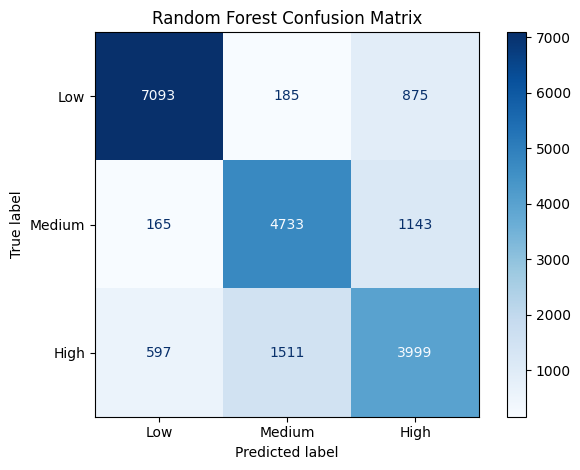

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,
    pred_rf,
    display_labels=['Low', 'Medium', 'High'],  # or sorted(y_test.unique())
    cmap='Blues',
    normalize=None)

plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

### Model 2: Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=2000, multi_class='multinomial')
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print(classification_report(y_test, pred_lr, digits=3))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

        High      0.767     0.752     0.759      8153
         Low      0.615     0.727     0.666      6041
      Medium      0.553     0.469     0.507      6107

    accuracy                          0.659     20301
   macro avg      0.645     0.649     0.644     20301
weighted avg      0.658     0.659     0.656     20301



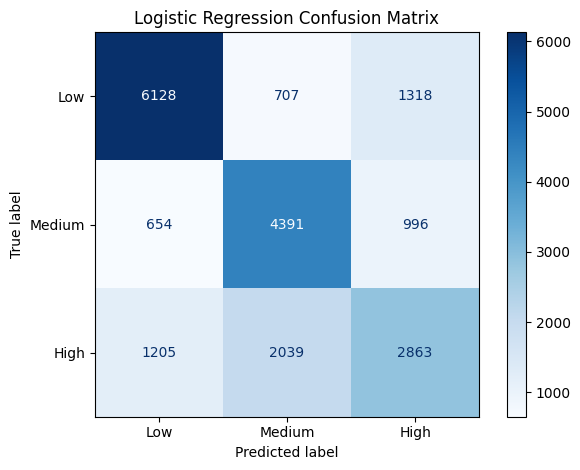

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,
    pred_lr,
    display_labels=['Low', 'Medium', 'High'],
    cmap='Blues',
    normalize=None)

plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.show()

### Model 3: XGBOOST

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# Numpy arrays for XGB
Xtr = X_train.to_numpy()
Xte = X_test.to_numpy()

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method='hist',
    eval_metric='mlogloss',
    random_state=4,
    n_jobs=-1)
xgb.fit(Xtr, y_train_enc)

pred_xgb_enc = xgb.predict(Xte)
pred_xgb = le.inverse_transform(pred_xgb_enc)

print(classification_report(y_test, pred_xgb, digits=3))

              precision    recall  f1-score   support

        High      0.901     0.882     0.892      8153
         Low      0.734     0.786     0.759      6041
      Medium      0.676     0.648     0.661      6107

    accuracy                          0.783     20301
   macro avg      0.770     0.772     0.771     20301
weighted avg      0.784     0.783     0.783     20301



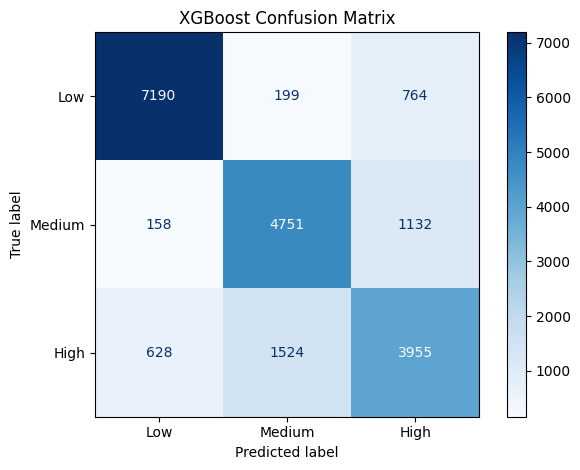

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,
                                       pred_xgb,
                                       display_labels=['Low', 'Medium', 'High'],
                                       cmap='Blues',
                                       normalize=None)

plt.title('XGBoost Confusion Matrix')
plt.tight_layout()
plt.show()

### Model 4: Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=50, random_state=4)
dt.fit(X_train, y_train)

pred_dt = dt.predict(X_test)

print(classification_report(y_test, pred_dt, digits=3))

              precision    recall  f1-score   support

        High      0.887     0.862     0.874      8153
         Low      0.731     0.778     0.754      6041
      Medium      0.650     0.633     0.641      6107

    accuracy                          0.768     20301
   macro avg      0.756     0.758     0.756     20301
weighted avg      0.769     0.768     0.768     20301



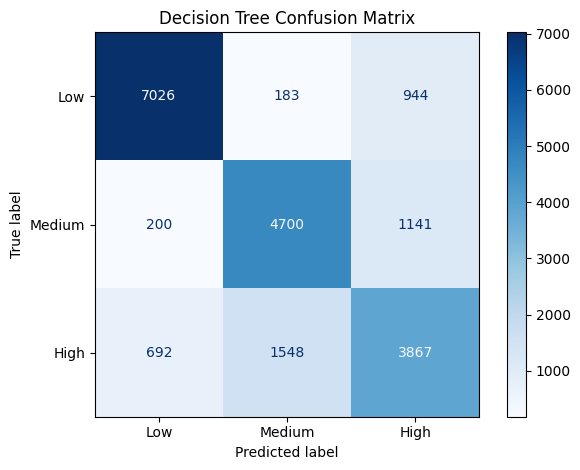

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,
                                        pred_dt,
                                        display_labels=['Low','Medium','High'],
                                        cmap='Blues',
                                        normalize=None)
plt.title('Decision Tree Confusion Matrix')
plt.tight_layout()
plt.show()

## Model Selection: XGBOOST

### Top Most Important Features

In [ ]:
xgb_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
top_xgb = xgb_importances.sort_values(ascending=False).head(15)


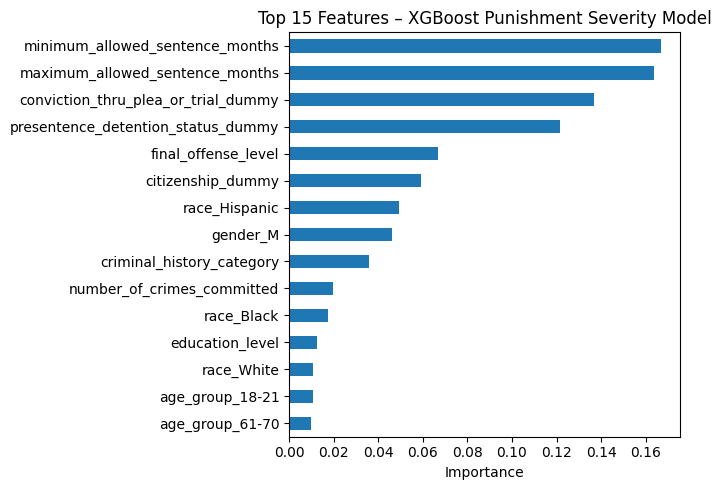

,0
minimum_allowed_sentence_months,0.167055
maximum_allowed_sentence_months,0.163891
conviction_thru_plea_or_trial_dummy,0.136748
presentence_detention_status_dummy,0.121672
final_offense_level,0.066863
citizenship_dummy,0.059110
race_Hispanic,0.049123
gender_M,0.045981
criminal_history_category,0.035753
number_of_crimes_committed,0.019593


In [ ]:
plt.figure(figsize=(7, 5))
top_xgb.sort_values().plot(kind='barh')
plt.title('Top 15 Features – XGBoost Punishment Severity Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

top_xgb

## Modelling - Demographic Features

In [ ]:
demo_preds = ['race','gender','citizenship_dummy','age_group','education_level', 'number_of_dependents']

y = df_clean['punishment_severity']  # Target
X = pd.get_dummies(df_clean[demo_preds], drop_first=True) # Predictors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

### Random Forest - Demographics

In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    random_state=4,
    n_jobs=-1)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print(classification_report(y_test, pred_rf, digits=3))

              precision    recall  f1-score   support

        High      0.648     0.780     0.708      8153
         Low      0.510     0.508     0.509      6041
      Medium      0.428     0.313     0.362      6107

    accuracy                          0.559     20301
   macro avg      0.529     0.534     0.526     20301
weighted avg      0.541     0.559     0.545     20301



### Logisitic Regression - Demographics

In [ ]:
lr = LogisticRegression(max_iter=2000, multi_class='multinomial')
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print(classification_report(y_test, pred_lr, digits=3))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

        High      0.614     0.672     0.642      8153
         Low      0.493     0.470     0.481      6041
      Medium      0.402     0.370     0.386      6107

    accuracy                          0.521     20301
   macro avg      0.503     0.504     0.503     20301
weighted avg      0.514     0.521     0.517     20301



### Decision Tree - Demographics

In [ ]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=50, random_state=4)
dt.fit(X_train, y_train)

pred_dt = dt.predict(X_test)

print(classification_report(y_test, pred_dt, digits=3))

              precision    recall  f1-score   support

        High      0.648     0.783     0.709      8153
         Low      0.511     0.488     0.499      6041
      Medium      0.432     0.331     0.375      6107

    accuracy                          0.559     20301
   macro avg      0.530     0.534     0.528     20301
weighted avg      0.542     0.559     0.546     20301



### XGBOOST - Demographics (BEST)

In [ ]:

# Labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# Arrays
Xtr = X_train.to_numpy()
Xte = X_test.to_numpy()

# Balanced sample weights for training
sw_train = compute_sample_weight(class_weight='balanced', y=y_train_enc)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method='hist',
    eval_metric='mlogloss',
    random_state=4,
    n_jobs=-1)

# Fit Model
xgb.fit(Xtr, y_train_enc, sample_weight=sw_train)

# Predict
pred_xgb_enc = xgb.predict(Xte)
pred_xgb = le.inverse_transform(pred_xgb_enc)
print(classification_report(y_test, pred_xgb, digits=3))


              precision    recall  f1-score   support

        High      0.693     0.680     0.687      8153
         Low      0.499     0.509     0.504      6041
      Medium      0.414     0.416     0.415      6107

    accuracy                          0.550     20301
   macro avg      0.535     0.535     0.535     20301
weighted avg      0.551     0.550     0.550     20301



In [ ]:
xgb_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
top_xgb = xgb_importances.sort_values(ascending=False).head(15)

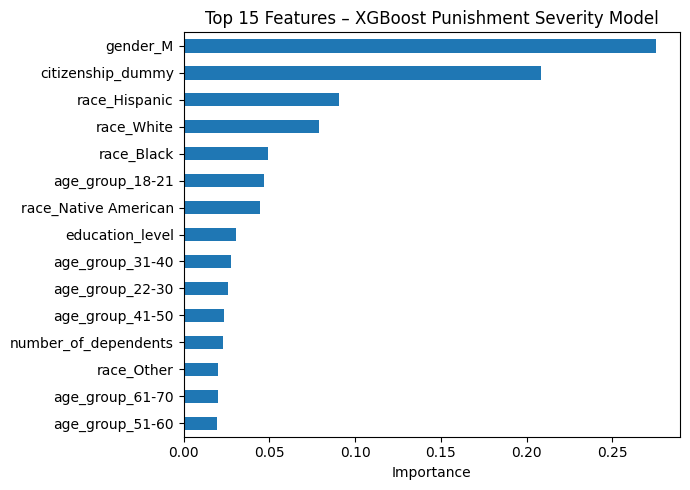

,0
gender_M,0.275576
citizenship_dummy,0.208111
race_Hispanic,0.090306
race_White,0.079116
race_Black,0.049360
age_group_18-21,0.046776
race_Native American,0.044335
education_level,0.030581
age_group_31-40,0.027392
age_group_22-30,0.025629


In [ ]:
plt.figure(figsize=(7, 5))
top_xgb.sort_values().plot(kind='barh')
plt.title('Top 15 Features – XGBoost Punishment Severity Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

top_xgb

## Further Analytics

### Race in High Severity

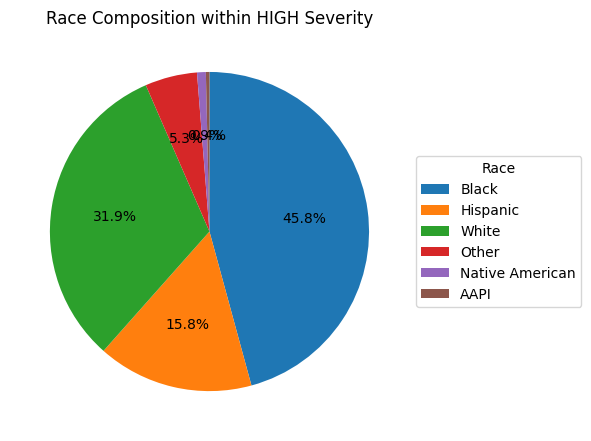

In [ ]:
race_order = df_clean['race'].value_counts().index

race_counts = (
    df_clean.loc[df_clean['punishment_severity'] == 'High', 'race']
            .value_counts()
    .reindex(race_order, fill_value=0))

plt.figure(figsize=(6, 6))
race_counts.plot(
    kind='pie',
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False)

plt.title('Race Composition within HIGH Severity')
plt.ylabel('')
plt.legend(
    race_counts.index,
    title='Race',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()


### Race in Medium Severity

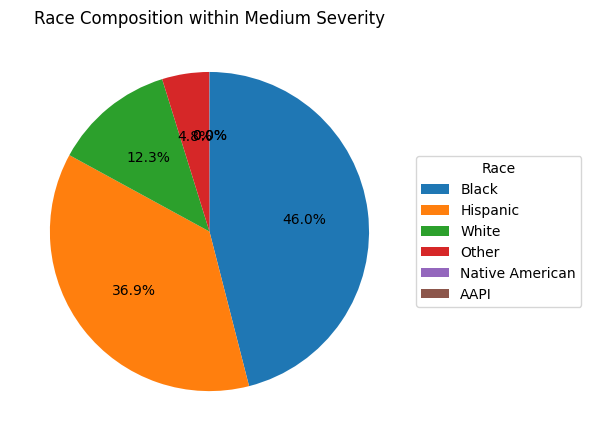

In [ ]:
race_counts = (
    df_clean.loc[df_clean['punishment_severity'] == 'Medium', 'race']
            .value_counts()
    .reindex(race_order, fill_value=0))

plt.figure(figsize=(6, 6))
race_counts.plot(
    kind='pie',
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False)

plt.title('Race Composition within Medium Severity')
plt.ylabel('')
plt.legend(
    race_counts.index,
    title='Race',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

### Race in Low Severity

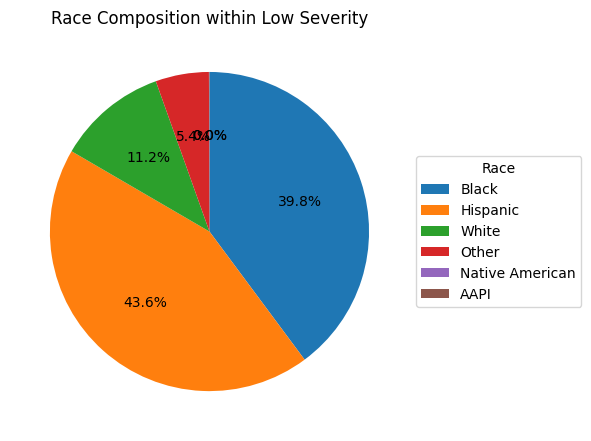

In [ ]:
race_counts = (
    df_clean.loc[df_clean['punishment_severity'] == 'Low', 'race']
            .value_counts()
    .reindex(race_order, fill_value=0))

plt.figure(figsize=(6, 6))
race_counts.plot(
    kind='pie',
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False)

plt.title('Race Composition within Low Severity')
plt.ylabel('')
plt.legend(
    race_counts.index,
    title='Race',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

### Gender in Crime Punishment

In [ ]:
df_clean.gender.value_counts()

,count
gender,
M,76781
F,24721


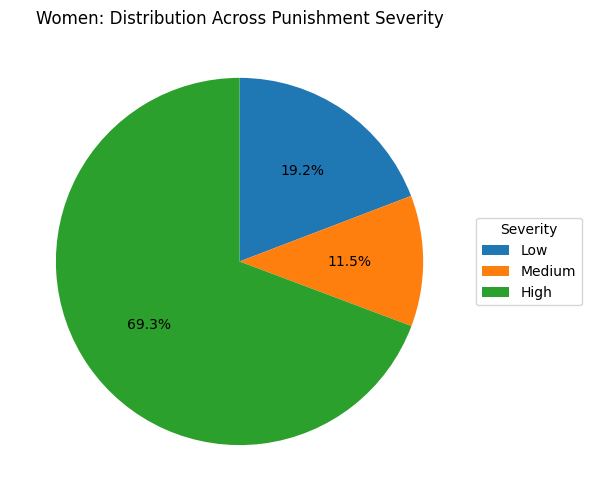

In [ ]:
df_women = df_clean[df_clean['gender'] == "F"]

sev_counts = df_women['punishment_severity'].value_counts().reindex(['Low', 'Medium', 'High'])

plt.figure(figsize=(6, 6))
sev_counts.plot(
    kind='pie',
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False)

plt.title('Women: Distribution Across Punishment Severity')
plt.ylabel('')
plt.legend(
    sev_counts.index,
    title='Severity',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()


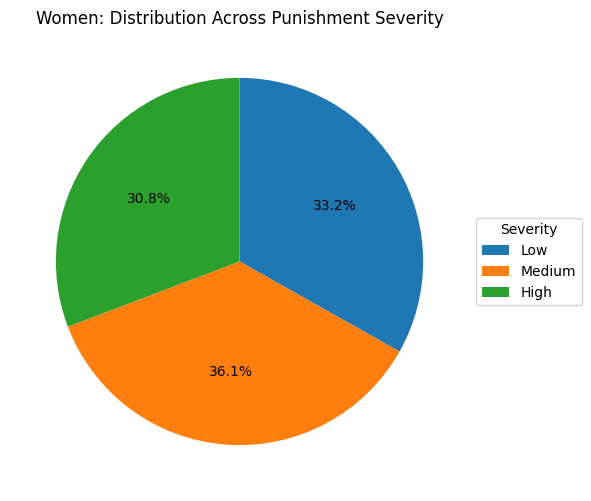

In [ ]:
df_women = df_clean[df_clean['gender'] == "M"]

sev_counts = df_women['punishment_severity'].value_counts().reindex(['Low', 'Medium', 'High'])

plt.figure(figsize=(6, 6))
sev_counts.plot(
    kind='pie',
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False)

plt.title('Women: Distribution Across Punishment Severity')
plt.ylabel('')
plt.legend(
    sev_counts.index,
    title='Severity',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()


## Summary / Findings

For my modeling, I tested four different models (Logistic Regression, Random Forest, XGBoost, and a Decision Tree) and and ran each model twice under different conditions. First, I trained all four models using the full set of predictors, which included both legal severity features and demographic features. All four models performed in the same general range, but XGBoost consistently came out ahead with roughly 78% accuracy and a macro F1 score of about 77%. Considering how much imputation and feature reconstruction I had to do, I’m satisfied with this result. It suggests that my imputation strategies were reasonalbe enough to maintain integrity.

After getting the full models working, I ran a second set of models using only demographic variables (race, gender, citizenship, age, education level, and dependents). The goal wasn't to make a perfect predicting model, but rather, it was to see whether demographics alone carry predictive power for punishment severity. The results were well above random guessing. The XGBOOST performed the best

Because I didn’t have reliable crime-type or offense-severity information for the full dataset (over 80% NaNs in these features), I can’t make definitive claims about institutional bias - for future enhancements, I would certainly find data that had sufficient crime severity information. Between the demographic-only model results and the descriptive analytics, it’s clear to me that severity outcomes are not uniform across groups. Gender and race really show measurable differences in how often individuals fall into Low, Medium, or High punishment categories. I can’t definitively speak to those causation of those patterns (or the explicit existence of bias in policing), but they do line up with broader known institutional biases in policing.